### **representative frame extractor + caption generator**

In [72]:
import os
import cv2
import json
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

device = "cuda" if torch.cuda.is_available() else "cpu"
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

def load_frames(folder_path):
    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith((".jpg", ".png"))])
    image_paths = [os.path.join(folder_path, f) for f in image_files]
    frames = [cv2.imread(p) for p in image_paths]
    return frames

def representative_extractor(frames, threshold_ratio=1.2):
    optical_flow = cv2.DISOpticalFlow_create(cv2.DISOPTICAL_FLOW_PRESET_FAST)
    magnitudes = []
    for i in range(len(frames) - 1):
        prev = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
        next = cv2.cvtColor(frames[i + 1], cv2.COLOR_BGR2GRAY)
        flow = optical_flow.calc(prev, next, None)
        magnitude = np.linalg.norm(flow, axis=2).mean()
        magnitudes.append(magnitude)

    avg = np.mean(magnitudes)
    rep_indices = [i + 1 for i, m in enumerate(magnitudes) if m >= threshold_ratio * avg]
    return rep_indices

def load_caption(frames, indices, processor, model, device):
    results = []
    for idx in indices:
        image = cv2.cvtColor(frames[idx], cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(image)
        inputs = processor(images=pil_img, return_tensors="pt").to(device)
        output = model.generate(**inputs)
        caption = processor.decode(output[0], skip_special_tokens=True)
        results.append({"frame": idx, "caption": caption})
    return results

def representative_caption_generator(root_dir, processor, model, device, threshold_ratio=1.2, output_path="captions.json"):
    result_dict = {}

    video_ids = sorted(os.listdir(root_dir))
    for video_id in tqdm(video_ids):
        folder_path = os.path.join(root_dir, video_id)
        if not os.path.isdir(folder_path):
            continue

        frames = load_frames(folder_path)
        if len(frames) != 18:
            print(f"[WARNING] {video_id}: expected 18 frames, found {len(frames)}")
            continue

        rep_indices = representative_extractor(frames, threshold_ratio)
        captions = load_caption(frames, rep_indices, processor, model, device)
        result_dict[video_id] = captions

    # 저장
    with open(output_path, "w") as f:
        json.dump(result_dict, f, indent=2)

    return result_dict

### **대표프레임 & 캡션 추출 테스트**

In [ ]:
root_dir = r"D:\RGB\training\applauding\18frames" 

test_video_id = "getty-21jun2002-montage-brazil-fans-watching-match-on-big-screen-in-town-video-id97966600_42"
test_folder_path = os.path.join(root_dir, test_video_id)

frames = load_frames(test_folder_path)

if len(frames) != 18:
    print(f"[ERROR] Expected 18 frames, found {len(frames)}")
else:
    rep_indices = representative_extractor(frames)
    captions = load_caption(frames, rep_indices, processor, model, device)

    print("대표 프레임 캡션 결과:")
    for cap in captions:
        print(f"  - Frame {cap['frame']}: {cap['caption']}")

    output_dict = {test_video_id: captions}
    with open("test_caption_output.json", "w") as f:
        json.dump(output_dict, f, indent=2)

    print()
    print(output_dict)

대표 프레임 캡션 결과:
  - Frame 17: a group of people in a crowd with their hands up

{'getty-21jun2002-montage-brazil-fans-watching-match-on-big-screen-in-town-video-id97966600_42': [{'frame': 17, 'caption': 'a group of people in a crowd with their hands up'}]}


### **전체 데이터에 대해 대표 프레임 & 캡션 추출**

In [18]:
# 전체 train & validation의 모든 액션 클래스 20개를 순회하며 대표 프레임과 캡션을 추출

import os
import json
from tqdm import tqdm

def process_all(root_dir, target_classes, output_dir, processor, model, device, threshold_ratio=1.2):
    os.makedirs(output_dir, exist_ok=True)
    
    for split in ["training", "validation"]:
        print(f"\n[INFO] Processing split: {split}")
        for class_name in tqdm(target_classes, desc=f"{split} split"):
            class_path = os.path.join(root_dir, split, class_name, "18frames")
            if not os.path.isdir(class_path):
                print(f"[SKIP] {class_path} not found.")
                continue
            
            result_dict = {}
            for video_id in sorted(os.listdir(class_path)):
                video_folder = os.path.join(class_path, video_id)
                if not os.path.isdir(video_folder): continue
                
                frames = load_frames(video_folder)
                if len(frames) != 18:
                    print(f"[WARNING] {video_id}: expected 18 frames, found {len(frames)}")
                    continue
                
                rep_indices = representative_extractor(frames, threshold_ratio)
                captions = load_caption(frames, rep_indices, processor, model, device)
                result_dict[video_id] = captions
            save_path = os.path.join(output_dir, f"{split}_{class_name}_captions.json")
            with open(save_path, "w") as f:
                json.dump(result_dict, f, indent=2)

In [19]:
target_classes = [
    "adult+female+singing", "adult+female+speaking", "adult+male+singing",
    "adult+male+speaking", "applauding", "ascending", "asking", "assembling",
    "autographing", "baking", "balancing", "barbecuing", "barking", "bending",
    "bicycling", "biting", "blowing", "boarding", "boating", "boiling"
    ]

root_dir = "D:/RGB"
output_dir = "D:/caption_json_output"
process_all(root_dir, target_classes, output_dir, processor, model, device)


[INFO] Processing split: training


training split: 100%|██████████| 20/20 [5:49:44<00:00, 1049.21s/it]  



[INFO] Processing split: validation


validation split: 100%|██████████| 20/20 [12:48<00:00, 38.43s/it]


### **AudioSet .tfrecord 처리**

#### .tfrecord 파일 확인

In [35]:
import tensorflow as tf

def _parse_function(example_proto):
    context_features = {
        "video_id": tf.io.FixedLenFeature([], tf.string),
        "labels": tf.io.VarLenFeature(tf.int64),
    }

    sequence_features = {
        "audio_embedding": tf.io.FixedLenSequenceFeature([], dtype=tf.string),  # [] not [128]
    }

    contexts, sequences = tf.io.parse_single_sequence_example(
        serialized=example_proto,
        context_features=context_features,
        sequence_features=sequence_features
    )

    # 🔹 Decode each frame (raw bytes) into 128-dim float32 vector
    audio_bytes = sequences["audio_embedding"]  # shape: [num_frames]
    audio_decoded = tf.map_fn(
        lambda x: tf.cast(tf.io.decode_raw(x, tf.uint8), tf.float32),
        audio_bytes,
        dtype=tf.float32
    )
    # Final shape: [num_frames, 128]
    
    # 🔹 Label vector (multi-hot)
    label_ids = tf.cast(tf.sparse.to_dense(contexts["labels"]), tf.int64)
    label_vector = tf.reduce_sum(tf.one_hot(label_ids, depth=527), axis=0)

    return audio_decoded, label_vector

In [38]:
tfrecord_path = r"C:\Users\swu\Desktop\audioset_v1_embeddings\eval\Y0.tfrecord"  # 또는 balanced_train_segments 등

# tf.data.Dataset 생성
raw_dataset = tf.data.TFRecordDataset(tfrecord_path)

# 파싱 함수 (앞서 정의한 _parse_function 사용)
parsed_dataset = raw_dataset.map(_parse_function)

# 샘플 몇 개 출력
for i, (audio_feat, label_vec) in enumerate(parsed_dataset.take(3)):
    print(f"Sample {i+1}")
    print("Audio Feature shape:", audio_feat)  # e.g., (10, 128)
    print("Label Vector shape:", label_vec.shape)    # e.g., (527,)
    print("Non-zero Labels (Indices):", tf.where(label_vec > 0).numpy().flatten())

Sample 1
Audio Feature shape: tf.Tensor(
[[148.  74. 140. ... 191.  54. 229.]
 [147. 150.  85. ... 234. 227. 255.]
 [156.  96. 124. ...   0. 112. 255.]
 ...
 [ 79.  88. 133. ... 187. 212.  60.]
 [119.  72. 146. ... 227.  20.  38.]
 [ 78.  82. 117. ...  62.  55. 255.]], shape=(10, 128), dtype=float32)
Label Vector shape: (527,)
Non-zero Labels (Indices): [182]
Sample 2
Audio Feature shape: tf.Tensor(
[[ 53. 169.  75. ...   0. 209. 185.]
 [  0. 171.  89. ...   0. 255. 159.]
 [  0. 196. 100. ...   0. 254. 208.]
 ...
 [  0. 181. 106. ... 255. 120. 255.]
 [  0. 235.  37. ... 124.  43. 255.]
 [  0. 213.  91. ... 186. 242. 184.]], shape=(10, 128), dtype=float32)
Label Vector shape: (527,)
Non-zero Labels (Indices): [373]
Sample 3
Audio Feature shape: tf.Tensor(
[[125.  65. 198. ... 153.  25. 255.]
 [209. 108.  62. ... 113. 218.  75.]
 [216. 117.  14. ...   0. 186. 102.]
 ...
 [197. 177. 137. ... 161. 116.   0.]
 [181. 241. 255. ... 255.  49.  34.]
 [185.  84. 171. ... 218. 138. 202.]], shape=

#### tfrecord >> npy 딕셔너리 변환

In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm

# 라벨 매핑 준비 (MID → 라벨 이름)
def load_label_mapping(label_csv_path):
    df = pd.read_csv(label_csv_path)
    mid_to_name = dict(zip(df["mid"], df["display_name"]))
    return mid_to_name

# 비디오 ID → MID 리스트 매핑
def load_segment_labels(segment_csv_path):
    with open(segment_csv_path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    lines = lines[3:]

    ytid_to_mids = {}
    for line in lines:
        try:
            parts = line.strip().split(",", 3) 
            if len(parts) < 4:
                continue
            ytid = parts[0].strip()
            labels = parts[3].strip().strip('"')
            ytid_to_mids[ytid] = labels
        except Exception as e:
            print(f"[Warning] Failed to parse line: {line} -- {e}")
            continue

    return ytid_to_mids

# TFRecord 파싱
def _parse_function(example_proto):
    context_features = {
        "video_id": tf.io.FixedLenFeature([], tf.string),
        "labels": tf.io.VarLenFeature(tf.int64),
    }
    sequence_features = {
        "audio_embedding": tf.io.FixedLenSequenceFeature([], dtype=tf.string),
    }

    contexts, features = tf.io.parse_single_sequence_example(
        example_proto,
        context_features=context_features,
        sequence_features=sequence_features
    )

    audio_bytes = tf.io.decode_raw(features["audio_embedding"], tf.uint8)
    audio_float = tf.cast(audio_bytes, tf.float32)
    audio_features = tf.reshape(audio_float, [-1, 128])  # shape: [10, 128]

    video_id = contexts["video_id"]
    return video_id, audio_features

def extract_and_save_audioset_features(tfrecord_dir, label_csv_path, segment_csv_path, output_path, limit=None):
    print("Loading label mappings...")
    mid_to_name = load_label_mapping(label_csv_path)
    ytid_to_mids = load_segment_labels(segment_csv_path)

    feature_dict = {}
    tfrecord_files = [f for f in os.listdir(tfrecord_dir) if f.endswith(".tfrecord")]
    tfrecord_files.sort()

    for filename in tqdm(tfrecord_files, desc="Processing TFRecords"):
        dataset = tf.data.TFRecordDataset(os.path.join(tfrecord_dir, filename))
        for raw_record in dataset:
            try:
                video_id_tensor, audio_feat = _parse_function(raw_record)
                video_id = video_id_tensor.numpy().decode("utf-8")

                mids_str = ytid_to_mids.get(video_id, "")
                mids = mids_str.split(",") if mids_str else []
                label_names = [mid_to_name.get(mid.strip(), mid.strip()) for mid in mids]

                feature_dict[video_id] = {
                    "features": audio_feat.numpy(),  # shape: [10, 128]
                    "labels": label_names
                }

                if limit and len(feature_dict) >= limit:
                    break
            except Exception as e:
                print(f"⚠️ Error in {filename}: {e}")
        if limit and len(feature_dict) >= limit:
            break

    np.save(output_path, feature_dict)
    print(f"Saved {len(feature_dict)} samples to {output_path}")

In [63]:
extract_and_save_audioset_features(
    tfrecord_dir=r"C:\Users\swu\Desktop\audioset_v1_embeddings\bal_train",  # .tfrecord 파일들 위치
    label_csv_path=r"C:\Users\swu\Desktop\class_labels_indices.csv",  # MID → label name
    segment_csv_path=r"C:\Users\swu\Desktop\balanced_train_segments.csv",  # YTID → MID
    output_path=r"C:\Users\swu\Desktop\audioset_v1_embeddings\audioset_balanced_train.npy",
)

Loading label mappings...


Processing TFRecords: 100%|██████████| 1444/1444 [00:36<00:00, 39.17it/s]


Saved 7971 samples to C:\Users\swu\Desktop\audioset_v1_embeddings\audioset_balanced_train.npy


In [ ]:
import numpy as np

npy_path = r"C:\Users\swu\Desktop\audioset_v1_embeddings\audioset_balanced_train.npy"
data = np.load(npy_path, allow_pickle=True).item()  # dict 형태로 저장되어 있으니 .item() 필요

for i, (vid, info) in enumerate(data.items()):
    print(f"\n🔹 Sample {i+1}")
    print("▶ Video ID:", vid)
    print("▶ Audio Feature Shape:", info["features"])
    print("▶ Labels:", info["labels"])
    if i >= 10:
        break  # 처음 5개까지만 출력

#### AudioSet class 별 평균 오디오 피처 계산

In [65]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm

data = np.load(r"C:\Users\swu\Desktop\audioset_v1_embeddings\audioset_balanced_train.npy", allow_pickle=True).item()

class_to_features = defaultdict(list)

for video_id, sample in tqdm(data.items(), desc="Aggregating features"):
    features = sample["features"]  # shape: [T, 128]
    mean_feat = np.mean(features, axis=0)  # [128]

    for label in sample["labels"]:
        class_to_features[label].append(mean_feat)

class_to_avg = {}

for label, feats in class_to_features.items():
    class_to_avg[label] = np.mean(feats, axis=0)  # shape: [128]

# 저장
np.save(r"C:\Users\swu\Desktop\audioset_v1_embeddings\audioset_class_embeddings.npy", class_to_avg)
print("클래스별 평균 오디오 피처 저장 완료")

Aggregating features: 100%|██████████| 7971/7971 [00:00<00:00, 143973.46it/s]

클래스별 평균 오디오 피처 저장 완료


In [81]:
import numpy as np

class_avg = np.load(r"C:\Users\swu\Desktop\audioset_v1_embeddings\audioset_class_embeddings.npy", allow_pickle=True).item()

print(f"총 클래스 수: {len(class_avg)}")

shapes = set(v.shape for v in class_avg.values())
print(f"평균 피처 벡터 shape: {shapes}")

for i, (label, vec) in enumerate(class_avg.items()):
    print(f"\n▶ 클래스: {label}")
    print(f"▶ 피처 벡터 일부: {vec[:10]}")
    if i == 4:
        break

총 클래스 수: 527
평균 피처 벡터 shape: {(128,)}

▶ 클래스: Smoke detector, smoke alarm
▶ 피처 벡터 일부: [ 78.59524  103.857155 154.19046   55.095238 134.77145  127.023796
  91.62382  115.728584 196.56192  173.10953 ]

▶ 클래스: Speech
▶ 피처 벡터 일부: [ 82.53505 112.60884 152.10443 103.8108  142.13838 122.77496 125.67896
 103.21139 163.41327 136.16269]

▶ 클래스: Gush
▶ 피처 벡터 일부: [ 45.06111  148.96667  151.23334   32.438885 160.13889  151.89444
 157.95555  127.466675 198.6389   161.48334 ]

▶ 클래스: Singing
▶ 피처 벡터 일부: [186.8782   148.11089  164.10733  125.74354  114.15198  134.94409
 152.76637  124.014824 117.961876 136.81686 ]

▶ 클래스: Bang
▶ 피처 벡터 일부: [156.15     171.58571  151.88571  150.425    139.4       76.89643
  97.25714   54.378567 117.66071   99.44643 ]


### **메인 학습 네트워크**

#### 대표 프레임 캡션 불러오기

In [75]:
import os
import json

def load_all_training_captions(caption_dir):
    """
    caption_dir: str - "D:/caption_json_output"
    returns: dict - { (class_name, video_id): [caption1, caption2, ...] }
    """
    caption_dict = {}

    for fname in os.listdir(caption_dir): 
        if fname.startswith("training_") and fname.endswith("_captions.json"):
            class_name = fname[len("training_"):-len("_captions.json")]
            file_path = os.path.join(caption_dir, fname)

            with open(file_path, "r", encoding="utf-8") as f:
                data = json.load(f)

            for video_id, captions in data.items():
                caption_dict[(class_name, video_id)] = captions
    return caption_dict

#### 캡션 - 라벨&피처 매핑

In [76]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

model = SentenceTransformer('all-MiniLM-L6-v2')

def load_label_feature_dict(npy_path):
    return np.load(npy_path, allow_pickle=True).item()

def map_caption_to_features(caption, label_feat_dict, top_k=5):
    label_names = list(label_feat_dict.keys())

    caption_emb = model.encode([caption]) 
    label_embs = model.encode(label_names)

    similarities = cosine_similarity(caption_emb, label_embs)[0]
    topk_indices = similarities.argsort()[::-1][:top_k]
    topk_scores = similarities[topk_indices]
    sim_mean = np.mean(topk_scores)

    selected = []
    for i in topk_indices:
        if similarities[i] >= sim_mean:
            label = label_names[i]
            feature = label_feat_dict[label]
            selected.append((label, feature))

    selected_labels = [x[0] for x in selected]
    selected_features = [x[1] for x in selected]
    return selected_labels, selected_features

테스트

In [84]:
label_feat_dict = load_label_feature_dict(r"C:\Users\swu\Desktop\audioset_v1_embeddings\audioset_class_embeddings.npy")
caption = "a man in a suit is dancing on a stage"

labels, features = map_caption_to_features(caption, label_feat_dict)
print("매핑된 라벨:", labels)

매핑된 라벨: ['Electronic dance music', 'Dance music', 'Male singing']


### **LSTM-based Generator 파이프라인**

In [86]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

class AudioFeatureGenerator(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=512, num_layers=2, output_dim=128):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out)

class AudioGenerationDataset(Dataset):
    def __init__(self, keys, gt_audio_dict, condition_dict, sequence_len=18, noise_dim=128):
        self.keys = keys
        self.gt_audio = gt_audio_dict
        self.condition = condition_dict
        self.seq_len = sequence_len
        self.noise_dim = noise_dim

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        gt = self.gt_audio[key]
        condition_mask = self.condition[key]['mask']    
        condition_vectors = self.condition[key]['features']

        noise = np.random.normal(0, 1, (self.seq_len, self.noise_dim)).astype(np.float32)

        # 조건 주입: condition 위치에는 condition vector, 나머지는 noise
        input_seq = np.where(np.expand_dims(condition_mask, axis=1), condition_vectors, noise)
        input_seq = torch.tensor(input_seq, dtype=torch.float32)
        gt = torch.tensor(gt, dtype=torch.float32)

        return input_seq, gt, key

def sequence_mse_loss(pred, target):
    return ((pred - target) ** 2).mean()

def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for x, y, _ in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

def validate(model, loader, criterion, device, visualize=False, num_samples=3):
    model.eval()
    total_loss = 0
    samples = []

    with torch.no_grad():
        for i in range(len(loader.dataset)):
            x, y, key = loader.dataset[i]
            x = x.unsqueeze(0).to(device)
            y = y.unsqueeze(0).to(device)
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item()

            if visualize and len(samples) < num_samples:
                samples.append((key, pred.squeeze(0).cpu().numpy(), y.squeeze(0).cpu().numpy()))

    if visualize:
        visualize_audio_similarity_samples(samples)

    return total_loss / len(loader.dataset)

def visualize_audio_similarity_samples(samples):
    for key, pred, gt in samples:
        cosine_sim = [cosine_similarity(pred[i:i+1], gt[i:i+1])[0, 0] for i in range(18)]
        mse = [np.mean((pred[i] - gt[i]) ** 2) for i in range(18)]

        fig, ax1 = plt.subplots()
        ax1.set_title(f"Similarity & MSE for video {key}")
        ax1.plot(cosine_sim, label='Cosine Similarity', marker='o', color='blue')
        ax1.set_ylim(0, 1)
        ax1.set_ylabel('Cosine Similarity', color='blue')

        ax2 = ax1.twinx()
        ax2.plot(mse, label='MSE', marker='x', color='red')
        ax2.set_ylabel('MSE', color='red')

        fig.tight_layout()
        plt.xlabel('Frame')
        plt.legend()
        plt.show()

condition_dict 매핑  
-> 각 비디오에 대한 조건 입력을 매핑

In [87]:
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

caption_dict = load_all_training_captions(r"D:/caption_json_output")
label_feat_dict = load_label_feature_dict(
    r"C:\Users\swu\Desktop\audioset_v1_embeddings\audioset_class_embeddings.npy"
)
label_names = list(label_feat_dict.keys())
caption_encoder = SentenceTransformer('all-MiniLM-L6-v2')

label_embs = caption_encoder.encode(label_names)

# 캡션 → 오디오 피처 매핑
def map_caption_to_features_fast(caption, label_names, label_embs, label_feat_dict, top_k=5):
    caption_emb = caption_encoder.encode([caption])  # shape: (1, dim)
    similarities = cosine_similarity(caption_emb, label_embs)[0]  # shape: (num_labels,)
    
    topk_indices = similarities.argsort()[::-1][:top_k]
    topk_scores = similarities[topk_indices]
    sim_mean = np.mean(topk_scores)
    selected_feats = [
        label_feat_dict[label_names[i]]
        for i in topk_indices if similarities[i] >= sim_mean
    ]
    return selected_feats

In [88]:
condition_dict = {}

for key, captions in tqdm(caption_dict.items(), desc="Generating conditions"):
    mask = np.zeros(18, dtype=bool)
    features = np.zeros((18, 128), dtype=np.float32)
    
    for caption_info in captions:
        frame_idx = caption_info["frame"]
        caption_text = caption_info["caption"]

        selected_feats = map_caption_to_features_fast(
            caption_text, label_names, label_embs, label_feat_dict, top_k=5
        )

        if selected_feats:
            avg_feat = np.mean(selected_feats, axis=0)
            features[frame_idx] = avg_feat
            mask[frame_idx] = True

    condition_dict[key] = {
        "mask": mask,         # shape: (18,) boolean
        "features": features  # shape: (18, 128) float32
    }

Generating conditions: 100%|██████████| 24723/24723 [10:29<00:00, 39.27it/s] 


In [89]:
gt_train = np.load(r"D:\Audio-Feature\training\3.18frames-audio유효-split-feature\audio_filtered_train.npy", allow_pickle=True).item()
gt_val   = np.load(r"D:\Audio-Feature\training\3.18frames-audio유효-split-feature\audio_filtered_val.npy", allow_pickle=True).item()
train_keys = list(set(gt_train.keys()) & set(condition_dict.keys()))
val_keys   = list(set(gt_val.keys()) & set(condition_dict.keys()))

print(f"[INFO] Train samples: {len(train_keys)}")
print(f"[INFO] Validation samples: {len(val_keys)}")

train_dataset = AudioGenerationDataset(train_keys, gt_train, condition_dict)
val_dataset   = AudioGenerationDataset(val_keys, gt_val, condition_dict)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"[INFO] # of train batches: {len(train_loader)}")
print(f"[INFO] # of val batches: {len(val_loader)}")

sample_x, sample_y, sample_key = next(iter(train_loader))
print(f"[INFO] Sample input shape: {sample_x.shape}")  # (B, 18, 128)
print(f"[INFO] Sample target shape: {sample_y.shape}")  # (B, 18, 128)
print(f"[INFO] First sample key: {sample_key[0]}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AudioFeatureGenerator(input_dim=128, hidden_dim=512, output_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = sequence_mse_loss

for epoch in range(10):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss = validate(model, val_loader, criterion, device, visualize=False)
    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

[INFO] Train samples: 9074
[INFO] Validation samples: 1937
[INFO] # of train batches: 284
[INFO] # of val batches: 61
[INFO] Sample input shape: torch.Size([32, 18, 128])
[INFO] Sample target shape: torch.Size([32, 18, 128])
[INFO] First sample key: ('boarding', 'adult+male+speaking', 'adult+male+speaking', 'barking', 'balancing', 'biting', 'adult+male+singing', 'adult+female+singing', 'bicycling', 'adult+male+speaking', 'adult+female+speaking', 'blowing', 'adult+female+speaking', 'adult+female+speaking', 'boiling', 'adult+female+singing', 'adult+male+singing', 'assembling', 'adult+female+speaking', 'bicycling', 'boiling', 'boarding', 'adult+female+singing', 'adult+female+speaking', 'bicycling', 'baking', 'autographing', 'asking', 'adult+female+singing', 'blowing', 'ascending', 'baking')
[Epoch 1] Train Loss: 0.2451 | Val Loss: 0.1893
[Epoch 2] Train Loss: 0.1793 | Val Loss: 0.1743
[Epoch 3] Train Loss: 0.1683 | Val Loss: 0.1672
[Epoch 4] Train Loss: 0.1649 | Val Loss: 0.1660
[Epoch 5]

In [90]:
import torch
import numpy as np
from tqdm import tqdm

def generate_and_save_audio_features(model, dataset, device, save_path):
    model.eval()
    generated_dict = {}

    for i in tqdm(range(len(dataset)), desc="Generating audio features"):
        input_seq, _, key = dataset[i]
        input_seq = input_seq.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_seq)
        generated_dict[key] = output.squeeze(0).cpu().numpy()

    np.save(save_path, generated_dict)
    print(f"Saved {len(generated_dict)} generated features to: {save_path}")

In [91]:
generate_and_save_audio_features(
    model=model,
    dataset=train_dataset,
    device=device,
    save_path=r"D:\Gen-Audio\gen_audio_v1_train.npy"
)

generate_and_save_audio_features(
    model=model,
    dataset=val_dataset,
    device=device,
    save_path=r"D:\Gen-Audio\gen_audio_v1_val.npy"
)

Generating audio features: 100%|██████████| 9074/9074 [00:10<00:00, 834.59it/s]


Saved 9074 generated features to: D:\Gen-Audio\gen_audio_v1_train.npy


Generating audio features: 100%|██████████| 1937/1937 [00:02<00:00, 799.14it/s]

Saved 1937 generated features to: D:\Gen-Audio\gen_audio_v1_val.npy


### **Action Classification**

In [92]:
import torch
from torch.utils.data import Dataset
import pandas as pd

class ActionClassificationDataset(Dataset):
    def __init__(self, csv_path, rgb_dict, flow_dict, audio_dict, label_map, split_keys=None):
        self.df = pd.read_csv(csv_path)
        self.rgb = rgb_dict
        self.flow = flow_dict
        self.audio = audio_dict
        self.label_map = label_map
        self.keys = []
        for _, row in self.df.iterrows():
            key = (row['class_name'], row['video_id'])
            if key in rgb_dict and key in flow_dict and key in audio_dict and row['class_name'] in label_map:
                if split_keys is None or key in split_keys:
                    self.keys.append(key)

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        rgb = self.rgb[key]     # [18, 768]
        flow = self.flow[key]   # [18, 768]
        audio = self.audio[key] # [18, 128]

        video_feat = np.concatenate([rgb, flow], axis=-1)  # [18, 1536]
        full_feat = np.concatenate([video_feat, audio], axis=-1)  # [18, 1664]
        full_feat = torch.tensor(full_feat, dtype=torch.float32)

        label = self.label_map[key[0]]
        return full_feat.mean(dim=0), torch.tensor(label)  # [1664], int64
    
class ActionClassificationDatasetVisualOnly(Dataset):
    def __init__(self, csv_path, rgb_dict, flow_dict, label_map):
        import pandas as pd
        self.df = pd.read_csv(csv_path)
        self.rgb = rgb_dict
        self.flow = flow_dict
        self.label_map = label_map

        self.keys = []
        self.labels = []
        for _, row in self.df.iterrows():
            vid, cname = row["video_id"], row["class_name"]
            key = (cname, vid)
            if key in self.rgb and key in self.flow and cname in self.label_map:
                self.keys.append(key)
                self.labels.append(self.label_map[cname])

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        label = self.labels[idx]
        rgb = self.rgb[key]
        flow = self.flow[key]
        video_feat = np.concatenate([rgb, flow], axis=1)  # shape: [18, 768+768]
        video_feat = np.mean(video_feat, axis=0)          # [1536]
        return torch.tensor(video_feat, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [93]:
import torch.nn as nn

class ActionClassifier(nn.Module):
    def __init__(self, input_dim=1664, hidden_dim=512, num_classes=20):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [94]:
from sklearn.metrics import accuracy_score

def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

def evaluate(model, loader, criterion, device, return_preds=False):
    model.eval()
    preds, targets = [], []
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item() * x.size(0)
            preds.append(pred.argmax(dim=1).cpu())
            targets.append(y.cpu())
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    acc = accuracy_score(targets.numpy(), preds.numpy())
    if return_preds:
        return total_loss / len(loader.dataset), acc, targets.numpy(), preds.numpy()
    return total_loss / len(loader.dataset), acc

In [95]:
import numpy as np
from torch.utils.data import DataLoader

csv_path = r"D:\Audio-Feature\18-audio-train.csv"
label_map_path = r"C:\Users\swu\Desktop\20_class.txt"

label_map = {}

with open(label_map_path, "r", encoding="utf-8") as f:
    for line in f:
        name, idx = line.strip().split(",")
        label_map[name] = int(idx)

rgb_train = np.load(r"D:\Video-Feature\training\3.18frames-audio유효-split-feature\rgb_filtered_train.npy", allow_pickle=True).item()
flow_train = np.load(r"D:\Video-Feature\training\3.18frames-audio유효-split-feature\flow_filtered_train.npy", allow_pickle=True).item()
gt_audio_train = np.load(r"D:\Audio-Feature\training\3.18frames-audio유효-split-feature\audio_filtered_train.npy", allow_pickle=True).item()
gen_audio_train = np.load(r"D:\Gen-Audio\gen_audio_v1_train.npy", allow_pickle=True).item()

rgb_val = np.load(r"D:\Video-Feature\training\3.18frames-audio유효-split-feature\rgb_filtered_val.npy", allow_pickle=True).item()
flow_val = np.load(r"D:\Video-Feature\training\3.18frames-audio유효-split-feature\flow_filtered_val.npy", allow_pickle=True).item()
gt_audio_val = np.load(r"D:\Audio-Feature\training\3.18frames-audio유효-split-feature\audio_filtered_val.npy", allow_pickle=True).item()
gen_audio_val = np.load(r"D:\Gen-Audio\gen_audio_v1_val.npy", allow_pickle=True).item()

vis_train_dataset = ActionClassificationDatasetVisualOnly(csv_path, rgb_train, flow_train, label_map)
vis_val_dataset   = ActionClassificationDatasetVisualOnly(csv_path, rgb_val, flow_val, label_map)

vis_train_loader = DataLoader(vis_train_dataset, batch_size=32, shuffle=True)
vis_val_loader   = DataLoader(vis_val_dataset, batch_size=32, shuffle=False)

gt_train_dataset = ActionClassificationDataset(csv_path, rgb_train, flow_train, gt_audio_train, label_map)
gt_val_dataset   = ActionClassificationDataset(csv_path, rgb_val, flow_val, gt_audio_val, label_map)
gt_train_loader  = DataLoader(gt_train_dataset, batch_size=32, shuffle=True)
gt_val_loader    = DataLoader(gt_val_dataset, batch_size=32, shuffle=False)

gen_train_dataset = ActionClassificationDataset(csv_path, rgb_train, flow_train, gen_audio_train, label_map)
gen_val_dataset   = ActionClassificationDataset(csv_path, rgb_val, flow_val, gen_audio_val, label_map)
gen_train_loader  = DataLoader(gen_train_dataset, batch_size=32, shuffle=True)
gen_val_loader    = DataLoader(gen_val_dataset, batch_size=32, shuffle=False)

In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ActionClassifier(input_dim=1664).to(device)

# 모델 구성
model_gt   = ActionClassifier(input_dim=1664).to(device)
model_gen  = ActionClassifier(input_dim=1664).to(device)
model_vis  = ActionClassifier(input_dim=1536).to(device) 

optimizer_gt  = torch.optim.Adam(model_gt.parameters(), lr=1e-4)
optimizer_gen = torch.optim.Adam(model_gen.parameters(), lr=1e-4)
optimizer_vis = torch.optim.Adam(model_vis.parameters(), lr=1e-4)

criterion = nn.CrossEntropyLoss()

In [97]:
for epoch in range(10):
    train_loss_gt  = train(model_gt,  gt_train_loader,  optimizer_gt,  criterion, device)
    train_loss_gen = train(model_gen, gen_train_loader, optimizer_gen, criterion, device)
    train_loss_vis = train(model_vis, vis_train_loader, optimizer_vis, criterion, device)

    val_loss_gt,  val_acc_gt  = evaluate(model_gt,  gt_val_loader,  criterion, device)
    val_loss_gen, val_acc_gen = evaluate(model_gen, gen_val_loader, criterion, device)
    val_loss_vis, val_acc_vis = evaluate(model_vis, vis_val_loader, criterion, device)

    print('Audio Feature V1')
    print(f"[Epoch {epoch+1}]")
    print(f"GT     | Train Loss: {train_loss_gt:.4f} | Val Loss: {val_loss_gt:.4f} | Val Acc: {val_acc_gt:.4f}")
    print(f"Gen    | Train Loss: {train_loss_gen:.4f} | Val Loss: {val_loss_gen:.4f} | Val Acc: {val_acc_gen:.4f}")
    print(f"Visual | Train Loss: {train_loss_vis:.4f} | Val Loss: {val_loss_vis:.4f} | Val Acc: {val_acc_vis:.4f}")

Audio Feature V1
[Epoch 1]
GT     | Train Loss: 2.4862 | Val Loss: 2.1899 | Val Acc: 0.3614
Gen    | Train Loss: 2.7231 | Val Loss: 2.5341 | Val Acc: 0.2282
Visual | Train Loss: 2.7874 | Val Loss: 2.6431 | Val Acc: 0.1864
Audio Feature V1
[Epoch 2]
GT     | Train Loss: 2.1451 | Val Loss: 2.0718 | Val Acc: 0.4027
Gen    | Train Loss: 2.5061 | Val Loss: 2.4011 | Val Acc: 0.2566
Visual | Train Loss: 2.6453 | Val Loss: 2.6052 | Val Acc: 0.1962
Audio Feature V1
[Epoch 3]
GT     | Train Loss: 2.0565 | Val Loss: 1.9996 | Val Acc: 0.4130
Gen    | Train Loss: 2.4104 | Val Loss: 2.3297 | Val Acc: 0.2819
Visual | Train Loss: 2.6206 | Val Loss: 2.5762 | Val Acc: 0.2086
Audio Feature V1
[Epoch 4]
GT     | Train Loss: 1.9886 | Val Loss: 1.9500 | Val Acc: 0.4275
Gen    | Train Loss: 2.3683 | Val Loss: 2.2911 | Val Acc: 0.2912
Visual | Train Loss: 2.5931 | Val Loss: 2.5693 | Val Acc: 0.2075
Audio Feature V1
[Epoch 5]
GT     | Train Loss: 1.9508 | Val Loss: 1.9373 | Val Acc: 0.4337
Gen    | Train Loss:

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.show()

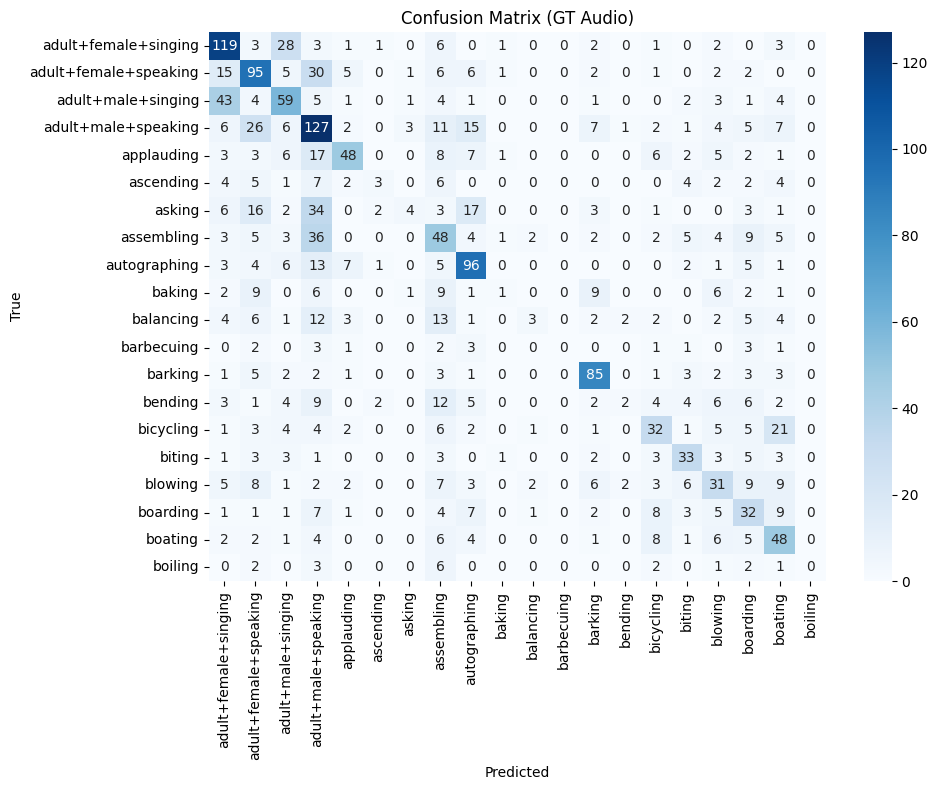

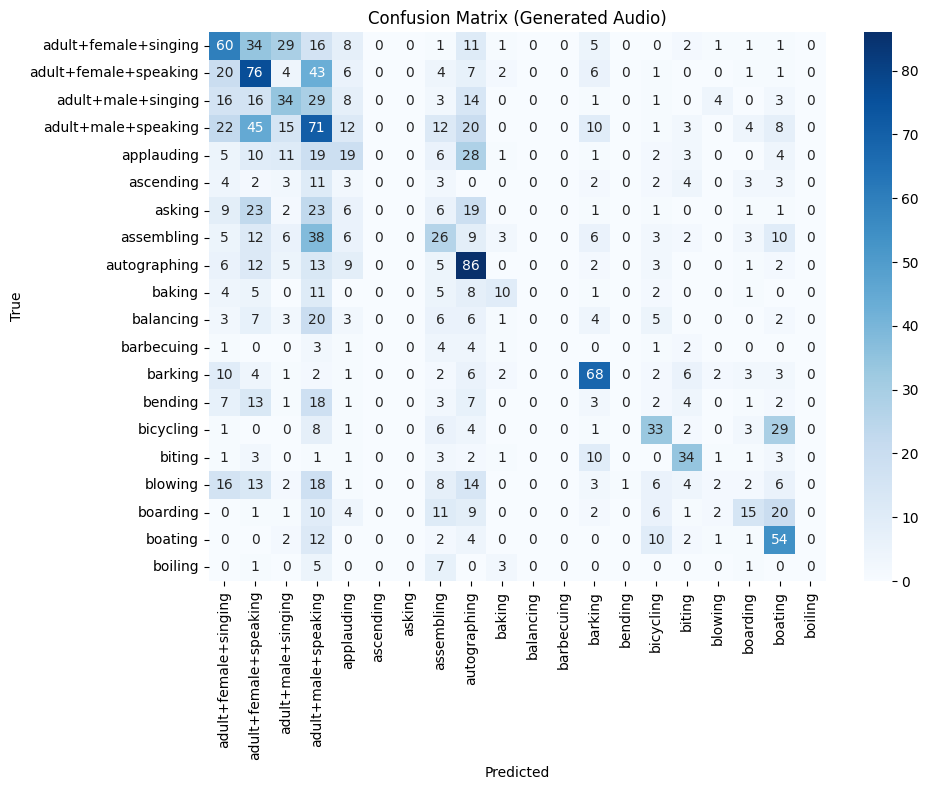

In [99]:
# 클래스 이름 리스트
class_names = [
    "adult+female+singing", "adult+female+speaking", "adult+male+singing", "adult+male+speaking",
    "applauding", "ascending", "asking", "assembling", "autographing", "baking",
    "balancing", "barbecuing", "barking", "bending", "bicycling", "biting",
    "blowing", "boarding", "boating", "boiling"
]

# Confusion Matrix (GT)
_, _, y_true_gt, y_pred_gt = evaluate(model_gt, gt_val_loader, criterion, device, return_preds=True)
plot_confusion_matrix(y_true_gt, y_pred_gt, class_names, title="Confusion Matrix (GT Audio)")

# Confusion Matrix (Generated)
_, _, y_true_gen, y_pred_gen = evaluate(model_gen, gen_val_loader, criterion, device, return_preds=True)
plot_confusion_matrix(y_true_gen, y_pred_gen, class_names, title="Confusion Matrix (Generated Audio)")

### **초기 결과**
대부분의 데이터가 adult+male+speaking 클래스로 매핑 됨
-> 그 원인이 비디오에 사람이 많이 감지되어 캡션에 반영되고, 사람 소리가 많이 반영됐기 때문이라고 가정

따라서 실제로 캡션-라벨 매핑 결과 사람 소리가 많이 매핑되었는지 확인 필요

In [34]:
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# 📌 Caption → Label feature 매핑 준비
caption_dict = load_all_training_captions(r"D:/caption_json_output")
label_feat_dict = load_label_feature_dict(r"C:/Users/swu/Desktop/audioset_v1_embeddings/audioset_class_embeddings.npy")
label_names = list(label_feat_dict.keys())

caption_encoder = SentenceTransformer('all-MiniLM-L6-v2')
label_embs = caption_encoder.encode(label_names)

# 📌 출력 딕셔너리들
condition_dict = {}
label_tracking_dict = {}  # ✅ 여기에 캡션 → 라벨 정보 저장

# 🔁 각 비디오에 대해 condition 생성
for key, captions in tqdm(caption_dict.items(), desc="Generating conditions"):
    mask = np.zeros(18, dtype=bool)
    features = np.zeros((18, 128), dtype=np.float32)
    matched_labels = []  # ✅ 이 비디오의 전체 대표 프레임에서 매핑된 라벨 모음

    for caption_info in captions:
        frame_idx = caption_info["frame"]
        caption_text = caption_info["caption"]

        # 🔎 Caption → Label 매핑
        caption_emb = caption_encoder.encode([caption_text])
        similarities = cosine_similarity(caption_emb, label_embs)[0]
        topk_indices = similarities.argsort()[::-1][:5]
        topk_scores = similarities[topk_indices]
        sim_mean = np.mean(topk_scores)

        selected_labels = [label_names[i] for i in topk_indices if similarities[i] >= sim_mean]
        selected_feats = [label_feat_dict[label] for label in selected_labels]

        if selected_feats:
            avg_feat = np.mean(selected_feats, axis=0)
            features[frame_idx] = avg_feat
            mask[frame_idx] = True
            matched_labels.extend(selected_labels)  # ✅ 라벨 기록

    condition_dict[key] = {
        "mask": mask,
        "features": features
    }

    label_tracking_dict[key] = matched_labels  # ✅ 매핑된 라벨 전체 기록

Generating conditions: 100%|██████████| 24723/24723 [19:12<00:00, 21.46it/s]


In [35]:
from collections import Counter

# 전체 라벨 빈도 분석
all_labels = sum(label_tracking_dict.values(), [])  # flatten
label_counts = Counter(all_labels)

print(label_counts.most_common(20))  # 가장 자주 매핑된 라벨 20개

[('Male speech, man speaking', 13270), ('Female speech, woman speaking', 12515), ('Crowd', 9284), ('Female singing', 5972), ('Dishes, pots, and pans', 4414), ('Animal', 4263), ('Frying (food)', 4094), ('Inside, small room', 3831), ('Boat, Water vehicle', 3432), ('Dog', 3345), ('Inside, large room or hall', 3135), ('Walk, footsteps', 3063), ('Male singing', 2800), ('Bicycle', 2567), ('Conversation', 2566), ('Skateboard', 2537), ('Hands', 2504), ('Microwave oven', 2462), ('Camera', 2407), ('Motorcycle', 2407)]


### **Human Sounds 필터링 기반 재실험**

In [52]:
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

def map_caption_to_features_filtered(
    caption, label_names, label_embs, label_feat_dict,
    top_k=10, human_labels=None, human_penalty=0.5, human_max=1
):
    """
    - 사람 소리 라벨에 penalty를 주고
    - top_k 중 평균 이상 라벨만 선택
    - 사람 소리 라벨은 최대 human_max개로 제한
    """
    caption_emb = caption_encoder.encode([caption])  # (1, dim)
    similarities = cosine_similarity(caption_emb, label_embs)[0]  # (num_labels,)

    label_sim_list = []
    for i in range(len(label_names)):
        label = label_names[i]
        sim = similarities[i]
        penalized_sim = sim * (human_penalty if label in human_labels else 1.0)
        label_sim_list.append((label, penalized_sim, sim))  # sim은 원본 유사도

    # top_k 선택 후 평균 이상만 필터링
    label_sim_list.sort(key=lambda x: x[1], reverse=True)
    topk = label_sim_list[:top_k]
    sim_mean = np.mean([x[1] for x in topk])

    selected = []
    human_count = 0
    for label, penalized_sim, orig_sim in topk:
        if penalized_sim >= sim_mean:
            if label in human_labels:
                if human_count >= human_max:
                    continue
                human_count += 1
            selected.append(label_feat_dict[label])

    return selected

# 사람 소리 라벨 리스트 로딩
with open(r"C:\Users\swu\Desktop\human_sounds.txt", "r", encoding="utf-8") as f:
    human_labels = set(line.strip() for line in f)

# Condition dict 생성
condition_dict = {}

for key, captions in tqdm(caption_dict.items(), desc="Generating conditions"):
    mask = np.zeros(18, dtype=bool)
    features = np.zeros((18, 128), dtype=np.float32)

    for caption_info in captions:
        frame_idx = caption_info["frame"]
        caption_text = caption_info["caption"]

        # 전략 B 매핑 함수 사용
        selected_feats = map_caption_to_features_filtered(
            caption_text,
            label_names,
            label_embs,
            label_feat_dict,
            top_k=10,
            human_labels=human_labels,
            human_penalty=0.5,
            human_max=1
        )

        if selected_feats:
            avg_feat = np.mean(selected_feats, axis=0)
            features[frame_idx] = avg_feat
            mask[frame_idx] = True

    condition_dict[key] = {
        "mask": mask,         # shape: (18,) boolean
        "features": features  # shape: (18, 128) float32
    }

Generating conditions:   9%|▊         | 2159/24723 [01:15<13:04, 28.78it/s]


KeyboardInterrupt: 

In [25]:
# 5. LSTM Generator 정의
class AudioFeatureGenerator(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=512, num_layers=2, output_dim=128):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out)

# 6. Custom Dataset
class AudioGenerationDataset(Dataset):
    def __init__(self, keys, gt_audio_dict, condition_dict, sequence_len=18, noise_dim=128):
        self.keys = keys
        self.gt_audio = gt_audio_dict
        self.condition = condition_dict
        self.seq_len = sequence_len
        self.noise_dim = noise_dim

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        gt = self.gt_audio[key]
        condition_mask = self.condition[key]['mask']
        condition_vectors = self.condition[key]['features']
        noise = np.random.normal(0, 1, (self.seq_len, self.noise_dim)).astype(np.float32)
        input_seq = np.where(np.expand_dims(condition_mask, axis=1), condition_vectors, noise)
        return torch.tensor(input_seq, dtype=torch.float32), torch.tensor(gt, dtype=torch.float32), key

# 7. 학습 유틸
def sequence_mse_loss(pred, target):
    return ((pred - target) ** 2).mean()

def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for x, y, _ in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

def validate(model, loader, criterion, device, visualize=False, num_samples=3):
    model.eval()
    total_loss = 0
    samples = []
    with torch.no_grad():
        for i in range(len(loader.dataset)):
            x, y, key = loader.dataset[i]
            x = x.unsqueeze(0).to(device)
            y = y.unsqueeze(0).to(device)
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item()
            if visualize and len(samples) < num_samples:
                samples.append((key, pred.squeeze(0).cpu().numpy(), y.squeeze(0).cpu().numpy()))
    if visualize:
        visualize_audio_similarity_samples(samples)
    return total_loss / len(loader.dataset)

def visualize_audio_similarity_samples(samples):
    for key, pred, gt in samples:
        cosine_sim = [cosine_similarity(pred[i:i+1], gt[i:i+1])[0, 0] for i in range(18)]
        mse = [np.mean((pred[i] - gt[i]) ** 2) for i in range(18)]
        fig, ax1 = plt.subplots()
        ax1.set_title(f"Similarity & MSE for video {key}")
        ax1.plot(cosine_sim, label='Cosine Similarity', marker='o', color='blue')
        ax1.set_ylim(0, 1)
        ax1.set_ylabel('Cosine Similarity', color='blue')
        ax2 = ax1.twinx()
        ax2.plot(mse, label='MSE', marker='x', color='red')
        ax2.set_ylabel('MSE', color='red')
        fig.tight_layout()
        plt.xlabel('Frame')
        plt.legend()
        plt.show()

# 8. 데이터 로딩 및 모델 학습
gt_train = np.load(r"D:\Audio-Feature\training\3.18frames-audio유효-split-feature\audio_filtered_train.npy", allow_pickle=True).item()
gt_val = np.load(r"D:\Audio-Feature\training\3.18frames-audio유효-split-feature\audio_filtered_val.npy", allow_pickle=True).item()
train_keys = list(set(gt_train.keys()) & set(condition_dict.keys()))
val_keys = list(set(gt_val.keys()) & set(condition_dict.keys()))
train_dataset = AudioGenerationDataset(train_keys, gt_train, condition_dict)
val_dataset = AudioGenerationDataset(val_keys, gt_val, condition_dict)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AudioFeatureGenerator(input_dim=128, hidden_dim=512, output_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = sequence_mse_loss

for epoch in range(10):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss = validate(model, val_loader, criterion, device, visualize=False)
    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# 9. 생성 피처 저장 함수
def generate_and_save_audio_features(model, dataset, device, save_path):
    model.eval()
    generated_dict = {}
    for i in tqdm(range(len(dataset)), desc="Generating audio features"):
        input_seq, _, key = dataset[i]
        input_seq = input_seq.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_seq)
        generated_dict[key] = output.squeeze(0).cpu().numpy()
    np.save(save_path, generated_dict)
    print(f"[✅] Saved {len(generated_dict)} generated features to: {save_path}")

# 10. 피처 저장
generate_and_save_audio_features(
    model=model,
    dataset=train_dataset,
    device=device,
    save_path=r"D:\Gen-Audio\gen_audio_v2_train.npy"
)
generate_and_save_audio_features(
    model=model,
    dataset=val_dataset,
    device=device,
    save_path=r"D:\Gen-Audio\gen_audio_v2_val.npy"
)

[Epoch 1] Train Loss: 0.2444 | Val Loss: 0.1892
[Epoch 2] Train Loss: 0.1791 | Val Loss: 0.1741
[Epoch 3] Train Loss: 0.1683 | Val Loss: 0.1674
[Epoch 4] Train Loss: 0.1655 | Val Loss: 0.1667
[Epoch 5] Train Loss: 0.1652 | Val Loss: 0.1667
[Epoch 6] Train Loss: 0.1650 | Val Loss: 0.1668
[Epoch 7] Train Loss: 0.1650 | Val Loss: 0.1666
[Epoch 8] Train Loss: 0.1649 | Val Loss: 0.1665
[Epoch 9] Train Loss: 0.1646 | Val Loss: 0.1659
[Epoch 10] Train Loss: 0.1644 | Val Loss: 0.1657


Generating audio features: 100%|██████████| 9074/9074 [00:11<00:00, 775.34it/s]


[✅] Saved 9074 generated features to: D:\Gen-Audio\gen_audio_v2_train.npy


Generating audio features: 100%|██████████| 1937/1937 [00:02<00:00, 775.88it/s]

[✅] Saved 1937 generated features to: D:\Gen-Audio\gen_audio_v2_val.npy


### 다시 추출한 피처로 **Action Classification**

In [56]:
import torch
from torch.utils.data import Dataset
import pandas as pd

class ActionClassificationDataset(Dataset):
    def __init__(self, csv_path, rgb_dict, flow_dict, audio_dict, label_map, split_keys=None):
        self.df = pd.read_csv(csv_path)
        self.rgb = rgb_dict
        self.flow = flow_dict
        self.audio = audio_dict
        self.label_map = label_map

        # class_name, video_id가 모두 존재하는 경우만 필터링
        self.keys = []
        for _, row in self.df.iterrows():
            key = (row['class_name'], row['video_id'])
            if key in rgb_dict and key in flow_dict and key in audio_dict and row['class_name'] in label_map:
                if split_keys is None or key in split_keys:
                    self.keys.append(key)

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        rgb = self.rgb[key]     # [18, 768]
        flow = self.flow[key]   # [18, 768]
        audio = self.audio[key] # [18, 128]

        video_feat = np.concatenate([rgb, flow], axis=-1)  # [18, 1536]
        full_feat = np.concatenate([video_feat, audio], axis=-1)  # [18, 1664]
        full_feat = torch.tensor(full_feat, dtype=torch.float32)

        label = self.label_map[key[0]]
        return full_feat.mean(dim=0), torch.tensor(label)  # [1664], int64
    
class ActionClassificationDatasetVisualOnly(Dataset):
    def __init__(self, csv_path, rgb_dict, flow_dict, label_map):
        import pandas as pd
        self.df = pd.read_csv(csv_path)
        self.rgb = rgb_dict
        self.flow = flow_dict
        self.label_map = label_map

        self.keys = []
        self.labels = []
        for _, row in self.df.iterrows():
            vid, cname = row["video_id"], row["class_name"]
            key = (cname, vid)
            if key in self.rgb and key in self.flow and cname in self.label_map:
                self.keys.append(key)
                self.labels.append(self.label_map[cname])

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        label = self.labels[idx]
        rgb = self.rgb[key]
        flow = self.flow[key]
        video_feat = np.concatenate([rgb, flow], axis=1)  # shape: [18, 768+768]
        video_feat = np.mean(video_feat, axis=0)          # [1536]
        return torch.tensor(video_feat, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [57]:
import torch.nn as nn

class ActionClassifier(nn.Module):
    def __init__(self, input_dim=1664, hidden_dim=512, num_classes=20):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [58]:
from sklearn.metrics import accuracy_score

def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

def evaluate(model, loader, criterion, device, return_preds=False):
    model.eval()
    preds, targets = [], []
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item() * x.size(0)
            preds.append(pred.argmax(dim=1).cpu())
            targets.append(y.cpu())
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    acc = accuracy_score(targets.numpy(), preds.numpy())
    if return_preds:
        return total_loss / len(loader.dataset), acc, targets.numpy(), preds.numpy()
    return total_loss / len(loader.dataset), acc

In [59]:
import numpy as np
from torch.utils.data import DataLoader

# 경로
csv_path = r"D:\Audio-Feature\18-audio-train.csv"
label_map_path = r"C:\Users\swu\Desktop\20_class.txt"

# 라벨 매핑
label_map = {}

with open(label_map_path, "r", encoding="utf-8") as f:
    for line in f:
        name, idx = line.strip().split(",")
        label_map[name] = int(idx)

# 데이터 로드
rgb_train = np.load(r"D:\Video-Feature\training\3.18frames-audio유효-split-feature\rgb_filtered_train.npy", allow_pickle=True).item()
flow_train = np.load(r"D:\Video-Feature\training\3.18frames-audio유효-split-feature\flow_filtered_train.npy", allow_pickle=True).item()
gt_audio_train = np.load(r"D:\Audio-Feature\training\3.18frames-audio유효-split-feature\audio_filtered_train.npy", allow_pickle=True).item()
gen_audio_train = np.load(r"D:\Gen-Audio\gen_audio_v2_train.npy", allow_pickle=True).item()

rgb_val = np.load(r"D:\Video-Feature\training\3.18frames-audio유효-split-feature\rgb_filtered_val.npy", allow_pickle=True).item()
flow_val = np.load(r"D:\Video-Feature\training\3.18frames-audio유효-split-feature\flow_filtered_val.npy", allow_pickle=True).item()
gt_audio_val = np.load(r"D:\Audio-Feature\training\3.18frames-audio유효-split-feature\audio_filtered_val.npy", allow_pickle=True).item()
gen_audio_val = np.load(r"D:\Gen-Audio\gen_audio_v2_val.npy", allow_pickle=True).item()

vis_train_dataset = ActionClassificationDatasetVisualOnly(csv_path, rgb_train, flow_train, label_map)
vis_val_dataset   = ActionClassificationDatasetVisualOnly(csv_path, rgb_val, flow_val, label_map)

vis_train_loader = DataLoader(vis_train_dataset, batch_size=32, shuffle=True)
vis_val_loader   = DataLoader(vis_val_dataset, batch_size=32, shuffle=False)

# Loader (GT 기준)
gt_train_dataset = ActionClassificationDataset(csv_path, rgb_train, flow_train, gt_audio_train, label_map)
gt_val_dataset   = ActionClassificationDataset(csv_path, rgb_val, flow_val, gt_audio_val, label_map)
gt_train_loader  = DataLoader(gt_train_dataset, batch_size=32, shuffle=True)
gt_val_loader    = DataLoader(gt_val_dataset, batch_size=32, shuffle=False)

# Loader (Generated Audio 기준)
gen_train_dataset = ActionClassificationDataset(csv_path, rgb_train, flow_train, gen_audio_train, label_map)
gen_val_dataset   = ActionClassificationDataset(csv_path, rgb_val, flow_val, gen_audio_val, label_map)
gen_train_loader  = DataLoader(gen_train_dataset, batch_size=32, shuffle=True)
gen_val_loader    = DataLoader(gen_val_dataset, batch_size=32, shuffle=False)

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ActionClassifier(input_dim=1664).to(device)

# 모델 구성
model_gt   = ActionClassifier(input_dim=1664).to(device)
model_gen  = ActionClassifier(input_dim=1664).to(device)
model_vis  = ActionClassifier(input_dim=1536).to(device)  # 오디오 제외

optimizer_gt  = torch.optim.Adam(model_gt.parameters(), lr=1e-4)
optimizer_gen = torch.optim.Adam(model_gen.parameters(), lr=1e-4)
optimizer_vis = torch.optim.Adam(model_vis.parameters(), lr=1e-4)

criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(10):
    train_loss_gt  = train(model_gt,  gt_train_loader,  optimizer_gt,  criterion, device)
    train_loss_gen = train(model_gen, gen_train_loader, optimizer_gen, criterion, device)
    train_loss_vis = train(model_vis, vis_train_loader, optimizer_vis, criterion, device)

    val_loss_gt,  val_acc_gt  = evaluate(model_gt,  gt_val_loader,  criterion, device)
    val_loss_gen, val_acc_gen = evaluate(model_gen, gen_val_loader, criterion, device)
    val_loss_vis, val_acc_vis = evaluate(model_vis, vis_val_loader, criterion, device)

    print('Audio Feature V2')
    print(f"[Epoch {epoch+1}]")
    print(f"  ✅ GT     | Train Loss: {train_loss_gt:.4f} | Val Loss: {val_loss_gt:.4f} | Val Acc: {val_acc_gt:.4f}")
    print(f"  🔷 Gen    | Train Loss: {train_loss_gen:.4f} | Val Loss: {val_loss_gen:.4f} | Val Acc: {val_acc_gen:.4f}")
    print(f"  ⚪ Visual | Train Loss: {train_loss_vis:.4f} | Val Loss: {val_loss_vis:.4f} | Val Acc: {val_acc_vis:.4f}")

Audio Feature V1
[Epoch 1]
  ✅ GT     | Train Loss: 2.4986 | Val Loss: 2.2154 | Val Acc: 0.3474
  🔷 Gen    | Train Loss: 2.7638 | Val Loss: 2.6028 | Val Acc: 0.2013
  ⚪ Visual | Train Loss: 2.7652 | Val Loss: 2.6389 | Val Acc: 0.1817
Audio Feature V1
[Epoch 2]
  ✅ GT     | Train Loss: 2.1624 | Val Loss: 2.0753 | Val Acc: 0.3955
  🔷 Gen    | Train Loss: 2.5951 | Val Loss: 2.5166 | Val Acc: 0.2246
  ⚪ Visual | Train Loss: 2.6498 | Val Loss: 2.6104 | Val Acc: 0.1905
Audio Feature V1
[Epoch 3]
  ✅ GT     | Train Loss: 2.0554 | Val Loss: 2.0242 | Val Acc: 0.4042
  🔷 Gen    | Train Loss: 2.5224 | Val Loss: 2.4767 | Val Acc: 0.2184
  ⚪ Visual | Train Loss: 2.6121 | Val Loss: 2.5794 | Val Acc: 0.2070
Audio Feature V1
[Epoch 4]
  ✅ GT     | Train Loss: 1.9971 | Val Loss: 1.9740 | Val Acc: 0.4146
  🔷 Gen    | Train Loss: 2.4900 | Val Loss: 2.4595 | Val Acc: 0.2287
  ⚪ Visual | Train Loss: 2.6011 | Val Loss: 2.5782 | Val Acc: 0.2029
Audio Feature V1
[Epoch 5]
  ✅ GT     | Train Loss: 1.9665 | Val